[Paper](https://link.springer.com/article/10.1007/s10489-020-01902-1) 
<br>[Dataset](https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3,ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import datetime

# Dataset Preparation


In [ ]:
#define paths
covid_path = '/content/drive/MyDrive/Colab Notebooks/Large CovidDataset/train/COVID19'                
noncovid_path = '/content/drive/MyDrive/Colab Notebooks/Large CovidDataset/train/NORMAL'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

## Fetch Images and Class Labels from Files

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

## Normalization
Model takes images in the form of array of pixels. Hence convert into array and normalize

In [ ]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

## Train Test Split
80 : 20 ratio

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(noncovid_images, noncovid_labels, test_size=0.2)

x_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
x_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

# EARLY STOPPING AND MODEL CHECKPOINT

In [ ]:
callbacks = [EarlyStopping(monitor='loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='loss',save_best_only=True)] 

# GRID SEARCH

In [ ]:
def modelGridConfig():
    n_epochs = [10,50, 100]
    n_batch_size=[100,200,512]
    n_optimizer = ['SGD', 'RMSprop',  'Adadelta', 'Adam']
    config = list()
    for i in n_epochs:
      for j in n_batch_size:
        for m in n_optimizer:
          cfg = [i, j, m]
          config.append(cfg)
    print("Total Configs: %d" % len(config))
    return config

# Building model

In [ ]:
cfg_list = modelGridConfig()
print(cfg_list)
count = 0
for cfg in cfg_list:
  count = count + 1
  print("config no", count)
  epoch, batch, optimizer = cfg
  res =  ResNet50(weights="imagenet", include_top=False,
      input_tensor=Input(shape=(224, 224, 3)))                              

  outputs = res.output
  outputs = Flatten(name="flatten")(outputs)
  outputs = Dropout(0.5)(outputs)
  outputs = Dense(2, activation="softmax")(outputs)

  model = Model(inputs=res.input, outputs=outputs)

  for layer in res.layers:
      layer.trainable = False
    
    
  now = datetime.datetime.now
  t = now()

  model.compile(
          loss='categorical_crossentropy', 
          optimizer=optimizer, 
          metrics=['accuracy']
  )
  history = model.fit(x_train,
                      y_train,
                      epochs=epoch,
                      callbacks=callbacks,
                      batch_size=batch,
                      validation_data=(x_test, y_test))
  
  results = model.evaluate(x_test, y_test)
  print(results)
  

  print('Training time: %s' % (now() - t))

Total Configs: 36
[[10, 100, 'SGD'], [10, 100, 'RMSprop'], [10, 100, 'Adadelta'], [10, 100, 'Adam'], [10, 200, 'SGD'], [10, 200, 'RMSprop'], [10, 200, 'Adadelta'], [10, 200, 'Adam'], [10, 512, 'SGD'], [10, 512, 'RMSprop'], [10, 512, 'Adadelta'], [10, 512, 'Adam'], [50, 100, 'SGD'], [50, 100, 'RMSprop'], [50, 100, 'Adadelta'], [50, 100, 'Adam'], [50, 200, 'SGD'], [50, 200, 'RMSprop'], [50, 200, 'Adadelta'], [50, 200, 'Adam'], [50, 512, 'SGD'], [50, 512, 'RMSprop'], [50, 512, 'Adadelta'], [50, 512, 'Adam'], [100, 100, 'SGD'], [100, 100, 'RMSprop'], [100, 100, 'Adadelta'], [100, 100, 'Adam'], [100, 200, 'SGD'], [100, 200, 'RMSprop'], [100, 200, 'Adadelta'], [100, 200, 'Adam'], [100, 512, 'SGD'], [100, 512, 'RMSprop'], [100, 512, 'Adadelta'], [100, 512, 'Adam']]
config no 1
94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/10
14/14 [==============================] - 17s 523ms/step - loss: 87.1308 - accuracy: 0.6013 - val_loss: 6.5762 - val_accuracy: 0.2688
Epoch 2/10

# Load Best Model

In [ ]:
model=load_model("best_model.h5")

In [ ]:
model.evaluate(x_test, y_test)

11/11 [==============================] - 2s 99ms/step - loss: 0.0426 - accuracy: 0.9855


[0.04257186874747276, 0.9855491518974304]

In [ ]:
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_32[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Predict

In [ ]:
y_pred = model.predict(x_test)

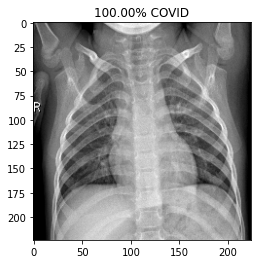

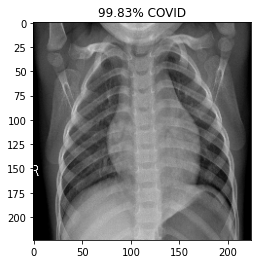

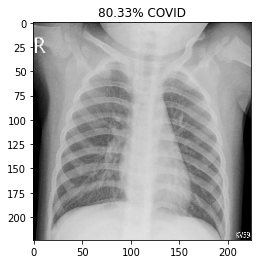

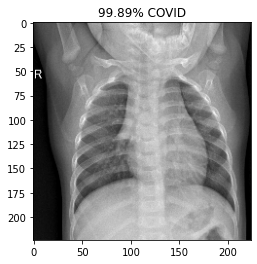

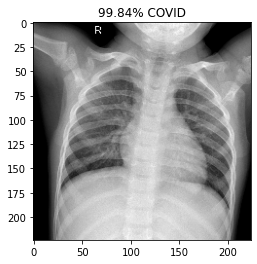

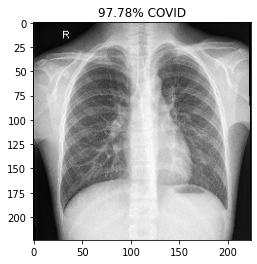

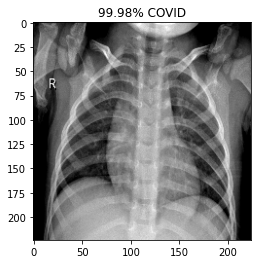

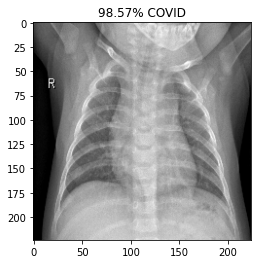

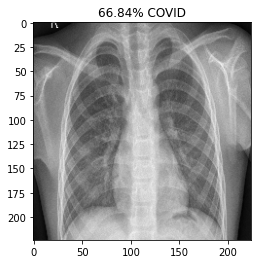

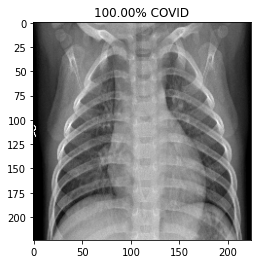

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(x_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

# RESULT PLOTTING

## Accuracy and Loss Plots

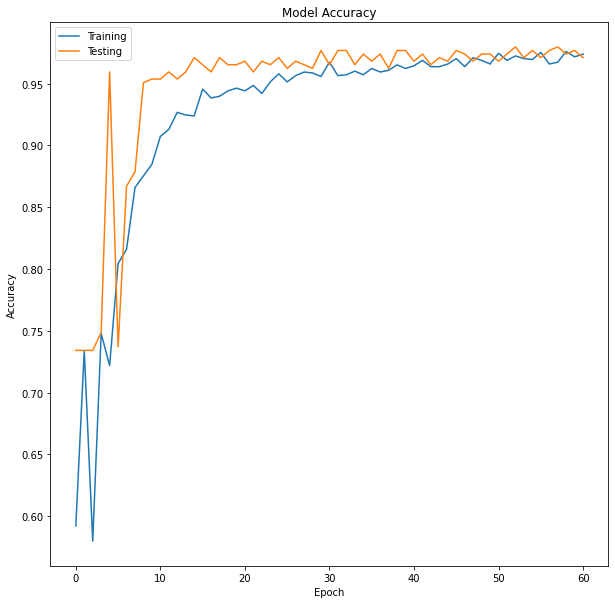

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()

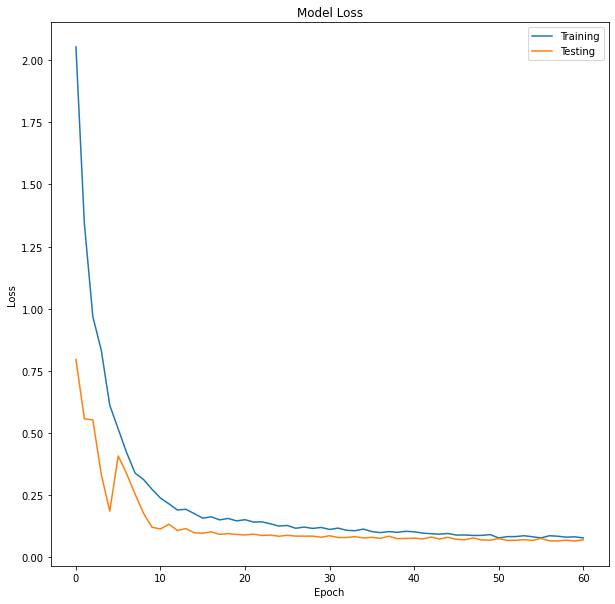

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

## ROC Curve

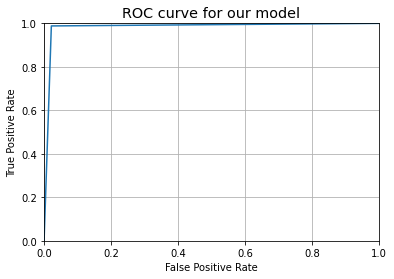

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## Confusion Matrix

Confusion Matrix without Normalization


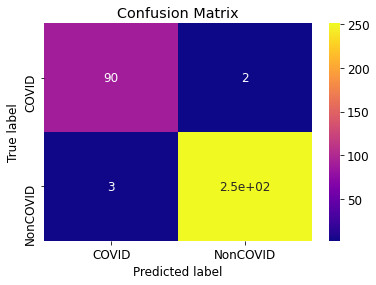

Confusion Matrix with Normalized Values


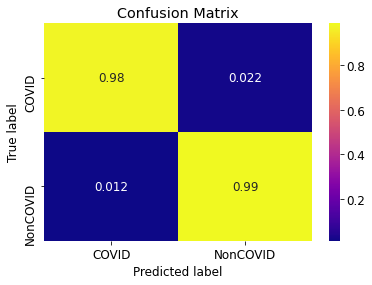

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        92
           1       0.99      0.99      0.99       254

    accuracy                           0.99       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.99      0.99      0.99       346

